The purpose of this notebook is to calculate the expression differences between different ancestry groups.

This notebook will focus on EUR vs EAS since these are the two major ancestry groups in the dataset.

# Set up the environment

In [1]:
#Arguments/Parameters
working_dir = "/home/jupyter/notebooks/Ancestry"
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET')

In [2]:
#Set up the environment

#load packages
library(tidyverse)
library(reshape2)
library(ggforce)
library(stringr)
library(ggrepel)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




# Format the datasets 

In [3]:
#Load in the ancestry fraction data
paste(working_dir, "/admixture", sep = "") %>% setwd()
ancestry.averages = read.table('ccle.projections.txt', sep = "\t", header = T)
head(ancestry.averages)

,EUR,EAS,AMR,SAS,AFR,DepMap_ID,lineage_subtype
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.058376,0.841298,0.028906,0.013521,0.057898,ACH-000380,plasma_cell
2,0.036494,0.863657,0.032450,0.008646,0.058753,ACH-000321,blood
3,0.011415,0.010345,0.003088,0.964387,0.010765,ACH-000857,breast
4,0.888580,0.017735,0.028750,0.055862,0.009074,ACH-000883,central_nervous_system
5,0.898368,0.014906,0.025614,0.052141,0.008971,ACH-000936,ovary
6,0.915203,0.006926,0.029091,0.026713,0.022068,ACH-000290,lung


In [4]:
#Load in the RNA-Seq data
system(glue::glue("
cd {working_dir}/ccle_ancestry_analysis
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/internal-21q4_v9-ccle-expression.csv .
"))


paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
expression = read.table('internal-21q4_v9-ccle-expression.csv', sep = ",")
expression[1,] = gsub(" .*", "", expression[1,]) #Remove the trailing number after the gene symbol [e.g A1BG (1) -> A1BG]
colnames(expression) <- as.character(expression[1, ]) #Then set those back to the column names
expression <- expression[-1,] #And remove the row from the dataset. The dataset should be all set now 
expression[2:ncol(expression)] = apply(expression[,2:ncol(expression)], 2, as.numeric)
expression = expression %>% rename(DepMap_ID = 1)

Now that all of the data is loaded, subset out the EUR and EAS cell lines.

In [5]:
#First, create a column to define the 'popmax' for each cell line.
ancestry.averages = ancestry.averages %>%
mutate(popmax = case_when(
                                EUR >= 0.8 ~ "European (EUR)",
                                EAS >= 0.8 ~ "East Asian (EAS)",
                                AMR >= 0.8 ~ "American (AMR)",
                                SAS >= 0.8 ~ "South Asian (SAS)",
                                AFR >= 0.8 ~ "African (AFR)")) %>%
mutate(popmax = replace_na(popmax, "Admixed"), .before = DepMap_ID)

head(ancestry.averages)

,EUR,EAS,AMR,SAS,AFR,DepMap_ID,lineage_subtype,popmax
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,0.058376,0.841298,0.028906,0.013521,0.057898,ACH-000380,plasma_cell,East Asian (EAS)
2,0.036494,0.863657,0.032450,0.008646,0.058753,ACH-000321,blood,East Asian (EAS)
3,0.011415,0.010345,0.003088,0.964387,0.010765,ACH-000857,breast,South Asian (SAS)
4,0.888580,0.017735,0.028750,0.055862,0.009074,ACH-000883,central_nervous_system,European (EUR)
5,0.898368,0.014906,0.025614,0.052141,0.008971,ACH-000936,ovary,European (EUR)
6,0.915203,0.006926,0.029091,0.026713,0.022068,ACH-000290,lung,European (EUR)


In [6]:
#Merge ancestry.averages and expression together
ancestry.and.expression = inner_join(ancestry.averages, expression)
ancestry.and.expression[1:5, 1:10]

Joining, by = "DepMap_ID"



,EUR,EAS,AMR,SAS,AFR,DepMap_ID,lineage_subtype,popmax,TSPAN6,TNMD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,0.058376,0.841298,0.028906,0.013521,0.057898,ACH-000380,plasma_cell,East Asian (EAS),0.07038933,0.00000000
2,0.036494,0.863657,0.032450,0.008646,0.058753,ACH-000321,blood,East Asian (EAS),1.19534760,0.00000000
3,0.011415,0.010345,0.003088,0.964387,0.010765,ACH-000857,breast,South Asian (SAS),5.61264738,0.00000000
4,0.888580,0.017735,0.028750,0.055862,0.009074,ACH-000883,central_nervous_system,European (EUR),5.71945727,0.00000000
5,0.898368,0.014906,0.025614,0.052141,0.008971,ACH-000936,ovary,European (EUR),5.18982456,0.02856915


# Create a plot to visualize the expression for ancestry-associated genes

We found a bunch of ancestry-associated genes in our previous analysis. Now, let's ask the question of whether different ancestry groups have differential expression of these genes.

In [7]:
#First, subset the dataframe so that it only includes the data we are interested in
df.subset.for.plotting = ancestry.and.expression %>%
select(popmax, DepMap_ID, CLSPN, RHD, UGT2B17, CHGB) %>%
filter(popmax %in% c("European (EUR)", "East Asian (EAS)")) %>%
rename("Ancestry" = popmax) %>%
melt()

head(df.subset.for.plotting)

Using Ancestry, DepMap_ID as id variables



,Ancestry,DepMap_ID,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,East Asian (EAS),ACH-000380,CLSPN,3.956057
2,East Asian (EAS),ACH-000321,CLSPN,3.047887
3,European (EUR),ACH-000883,CLSPN,4.670161
4,European (EUR),ACH-000936,CLSPN,3.874797
5,European (EUR),ACH-000290,CLSPN,6.754620
6,European (EUR),ACH-000885,CLSPN,4.133399


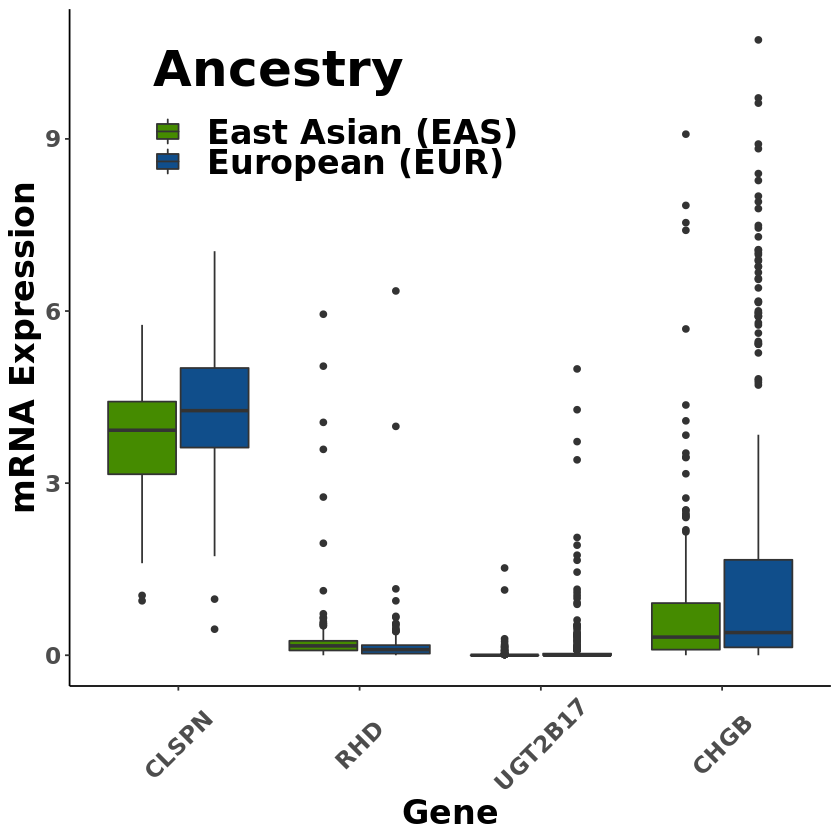

In [11]:
#Now plot the data
set.seed(42)
group.colors <- c("East Asian (EAS)" = "chartreuse4", "European (EUR)" = "dodgerblue4") #Make the color vector

df.subset.for.plotting %>%
ggplot(aes(x = variable, y = value, fill = Ancestry)) +
geom_boxplot(position=position_dodge(0.8)) +
scale_fill_manual(values = group.colors) +

theme_bw() +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 20, face = "bold"),
axis.title.y = element_text(color = "black", size = 20, face = "bold")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5)
) +

theme(
legend.position = c(0.35, 0.85),
legend.title=element_text(size=30), 
legend.text=element_text(size=20)
) +


xlab("Gene") +
ylab("mRNA Expression") 

#Put the exported image into the google bucket
ggsave("ancestry_association_expression.png", dpi = 300, width = 10, height = 10)
system(glue::glue("
cd {working_dir}/ccle_ancestry_analysis
gsutil cp ancestry_association_expression.png {workspace_bucket}
"))